In [18]:
import os
import re
import matplotlib.pyplot as plt
import albumentations as A
import numpy as np
import cv2

## Load Images


In [2]:
image_path = "./model/data/images"

image_names = []
mask_names = []

names = os.listdir(image_path)

In [3]:
for i in range(len(names)):

    name_split = names[i].split(".")

    # sample image name: night ride (8).png
    if (name_split[1]) == "png" and len(name_split) == 2:
        image_names.append(names[i])

    # sample mask name: night ride (8).png___fuse.png
    elif name_split[1][-4:] == "fuse":
        mask_names.append(names[i])

In [4]:
# pattern to find number from filenames
pattern = r"\d+"

# sort filenames based on number
image_names.sort(key=lambda x: int(re.findall(pattern, x)[0]))
mask_names.sort(key=lambda x: int(re.findall(pattern, x)[0]))

In [5]:
images = []
masks = []

for i in range(len(image_names)):

    img = plt.imread(image_path + "/" + image_names[i])
    img_rgb = img[:, :, :3]  # remove alpha channel from the image
    images.append(img_rgb)

    mask = plt.imread(image_path + "/" + mask_names[i])
    mask_rgb = mask[:, :, :3]  # remove alpha channel from the mask
    masks.append(mask_rgb)

## Data Exploration


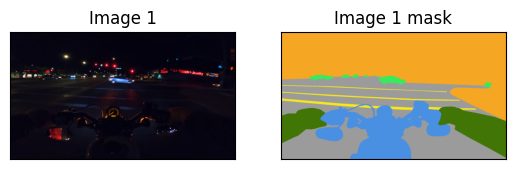

In [6]:
fig, axes = plt.subplots(1, 2)

axes[0].imshow(images[0])
axes[0].title.set_text("Image 1")

axes[1].imshow(masks[0])
axes[1].title.set_text("Image 1 mask")

for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])

## Split to Train/Test sets


In [7]:
train_images = images[:172]
test_images = images[172:]

In [8]:
train_masks = masks[:172]
test_masks = masks[172:]

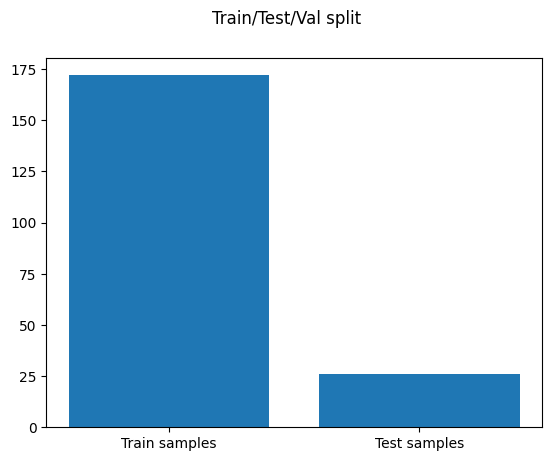

In [9]:
train_samples = len(train_images)
test_samples = len(test_images)

plt.bar(
    ["Train samples", "Test samples"],
    [train_samples, test_samples],
)
plt.suptitle("Train/Test/Val split")
plt.show()

## Data Augmentation


In [11]:
# make augmentation pipeline using albumentations
transform = A.Compose(
    [
        A.RandomCrop(width=1920, height=1080),
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.4),
        A.Rotate(limit=90, p=0.5),
        A.GridDistortion(p=0.5),
    ]
)

augmented_images = []
augmented_masks = []

for image, mask in zip(train_images, train_masks):
    for _ in range(2):
        augmented = transform(image=image, mask=mask)
        augmented_images.append(augmented["image"])
        augmented_masks.append(augmented["mask"])

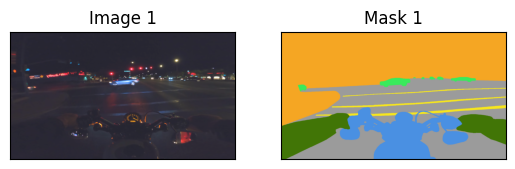

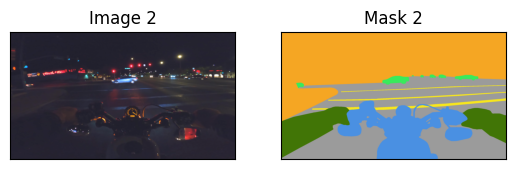

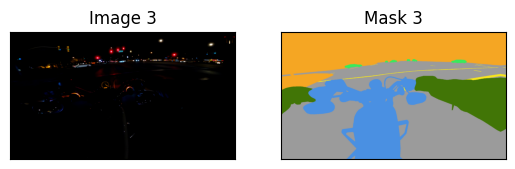

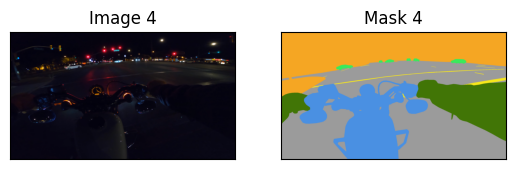

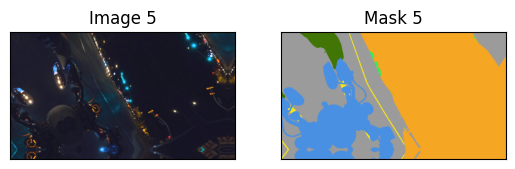

In [12]:
for i in range(5):
    fig, axes = plt.subplots(1, 2)

    axes[0].imshow(augmented_images[i])
    axes[0].title.set_text("Image " + str(i + 1))

    axes[1].imshow(augmented_masks[i])
    axes[1].title.set_text("Mask " + str(i + 1))

    for ax in axes:
        ax.set_xticks([])
        ax.set_yticks([])

## Release memory


In [13]:
del images
del masks
del train_images
del train_masks

## Process masks


In [15]:
label_colors = {
    (57, 234, 92): 0,  # movable
    (65, 117, 6): 1,  # driver
    (74, 144, 226): 2,  # bike
    (155, 155, 155): 3,  # road
    (245, 166, 35): 4,  # undrivable
    (248, 231, 28): 5  # lanemark
}

In [16]:
def convert_mask(mask, label_colors):
    # extract R, G, B channels
    channels = mask.transpose(2, 0, 1) * 255
    r, g, b = channels

    # convert RGB values to label indices using label_colors dictionary
    index = np.zeros((1080, 1920), dtype=np.uint8)
    for rgb, label in label_colors.items():
        mask = np.logical_and.reduce((r == rgb[0], g == rgb[1], b == rgb[2]))
        index[mask] = label

    # one-hot encode the label indices (give depth to label information)
    new_mask = np.eye(32, dtype=np.uint8)[index]

    return new_mask

In [17]:
processed_masks = []

for mask in augmented_masks:
    processed_masks.append(convert_mask(mask, label_colors))

In [19]:
train_images = []
mask_images = []
resolution = (192, 108)

# reshape images and masks
for image, mask in zip(augmented_images, processed_masks):
    train_images.append(cv2.resize(image, resolution))
    mask_images.append(cv2.resize(mask, resolution))

del augmented_images
del processed_masks

In [21]:
X_train = np.array(train_images[:300]).astype("float32")
X_val = np.array(train_images[300:]).astype("float32")
y_train = np.array(mask_images[:300]).astype("float32")
y_val = np.array(mask_images[300:]).astype("float32")